# cluster_toolkit Module

The cluster toolkit was designed for computing weak lensing profiles around clusters in DES. It has a straighforward API that we will explore in this notebook.

In [1]:
import cluster_toolkit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [3]:
#Starting from a power spectrum
#These can come from CAMB or CLASS or CCL or anything else
#They must be in units of Mpc/h comoving (standard for boltzmann codes)
klin = np.loadtxt("test_data/klin.txt")
Plin = np.loadtxt("test_data/plin.txt") #linear power spectrum
knl = np.loadtxt("test_data/knl.txt")
Pnl = np.loadtxt("test_data/pnl.txt") #nonlinear power spectrum

## Halo density profiles
This module has two halo density profiles available: the NFW profile and Einasto profiles. Here is how to calculate them.

In [4]:
Mass = 1e14 #Msun/h
Omega_m = 0.3 #Masses are all defined with respect to rho_m
#NFW concentration
conc = 5
#Einasto parameters
rs = 1.0 #Scale radius
a = 0.19 #Einasto exponent
#Radii of the profiles
Nr = 1000
r = np.logspace(-2, 3, Nr) #3D distance, Mpc/h comoving

In [5]:
rho_nfw = cluster_toolkit.density.rho_nfw_at_r(r, Mass, conc, Omega_m)
rho_ein = cluster_toolkit.density.rho_einasto_at_r(r, Mass, rs, a, Omega_m)

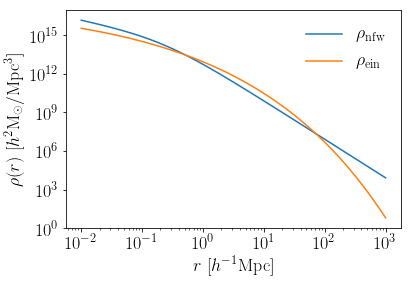

In [6]:
plt.loglog(r, rho_nfw,   label=r"$\rho_{\rm nfw}$")
plt.loglog(r, rho_ein,   label=r"$\rho_{\rm ein}$")
plt.xlabel(r"$r\ [h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$\rho(r)\ [h^2{\rm M_\odot}/{\rm Mpc^3}]$")
plt.legend(loc=0, frameon=False)
#plt.gcf().savefig("density_profile_example.png", dpi=300)

## Correlation functions
We can compute a variety of correlation functions. We can compute 1-halo terms (NFW, Einasto) and 2-halo terms (with/without bias) and combine them into halo-matter correlation functions.

In [7]:
#1-halo is NFW and the 2-halo term is based off the matter correlation function
xi_nfw = cluster_toolkit.xi.xi_nfw_at_r(r, Mass, conc, Omega_m)
xi_mm = cluster_toolkit.xi.xi_mm_at_r(r, knl, Pnl)

In [8]:
#Calculate the halo bias for this halo
bias = cluster_toolkit.bias.bias_at_M(Mass, klin, Plin, Omega_m)
#Complete the 2-halo term
xi_2halo = cluster_toolkit.xi.xi_2halo(bias, xi_mm)
xi_hm = cluster_toolkit.xi.xi_hm(xi_nfw, xi_2halo)

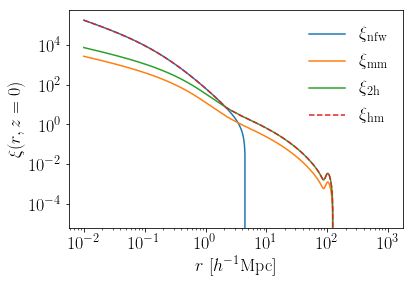

In [9]:
plt.loglog(r, xi_nfw,   label=r"$\xi_{\rm nfw}$")
plt.loglog(r, xi_mm,    label=r"$\xi_{\rm mm}$")
plt.loglog(r, xi_2halo, label=r"$\xi_{\rm 2h}$")
plt.loglog(r, xi_hm, ls='--', label=r"$\xi_{\rm hm}$")
plt.xlabel(r"$r\ [h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$\xi(r, z=0)$")
plt.legend(frameon=False)
#plt.gcf().savefig("xi_example.png", dpi=500)

# Bias, $\sigma(M)$, $\nu$
The code can also calculate things like the bias, matter variance and peak height.

Note: this is the Tinker+ 2010 bias


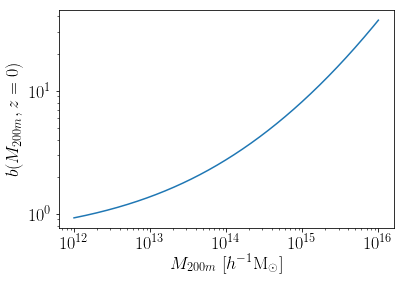

In [10]:
NM = 1000
Marr = np.logspace(12, 16, NM)
biases = cluster_toolkit.bias.bias_at_M(Marr, klin, Plin, Omega_m, delta=200)
plt.loglog(Marr, biases)
plt.xlabel(r"$M_{200m}\ [h^{-1}{\rm M}_\odot$]")
plt.ylabel(r"$b(M_{200m},z=0)$")
#plt.gcf().savefig("bias_example.png", dpi=500)
print("Note: this is the Tinker+ 2010 bias")

# Surface density
It can calculate surface density $\Sigma(R)$ which can be used for magnification or $\Delta\Sigma(R)$ for shear. Both of these can be modified by different miscentering models.

In [11]:
#Set up the projected radial separation
NR = 1000
Rp = np.logspace(-2, 2.4, NR) #Mpc/h comoving
Sigma  = cluster_toolkit.deltasigma.Sigma_at_R(Rp, r, xi_hm, Mass, conc, Omega_m)
Sigma_nfw = cluster_toolkit.deltasigma.Sigma_nfw_at_R(Rp, Mass, conc, Omega_m)

Rmis = 0.25 #Mpc/h; the miscentering length
Sigma_g2d  = cluster_toolkit.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)
Sigma_exp  = cluster_toolkit.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis, kernel="gamma")
Sigma_single  = cluster_toolkit.miscentering.Sigma_mis_single_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m, Rmis)

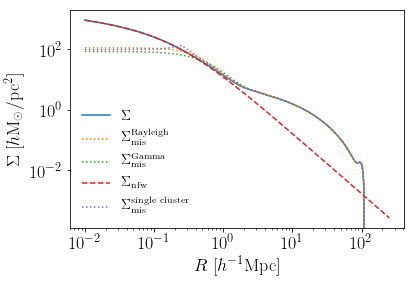

In [12]:
plt.loglog(Rp, Sigma, ls="-", label=r"$\Sigma$")
plt.loglog(Rp, Sigma_g2d, ls=":", label=r"$\Sigma_{\rm mis}^{\rm Rayleigh}$")
plt.loglog(Rp, Sigma_exp, ls=":", label=r"$\Sigma_{\rm mis}^{\rm Gamma}$")
plt.loglog(Rp, Sigma_nfw, ls="--", label=r"$\Sigma_{\rm nfw}$")
plt.loglog(Rp, Sigma_single, ls=":", label=r"$\Sigma_{\rm mis}^{\rm single\ cluster}$")
plt.ylabel(r"$\Sigma\ [h{\rm M_\odot/pc^2}$]")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.legend(frameon=False, fontsize=14)
#plt.gcf().savefig("Sigma_example.png", dpi=500)

# Differential surface mass density
The differential surface mass density $\Delta\Sigma$ is defined as
$$
\Delta\Sigma(R) = \bar{\Sigma}(<R) - \Sigma(R).
$$
This is why $R_p$ is passed in twice. First it is the domain of $\Delta\Sigma$ and then it is the domain of $\Sigma$.

In [13]:
DeltaSigma = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
DeltaSigma_nfw = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma_nfw, Mass, conc, Omega_m)
DeltaSigma_g2d = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_g2d)
DeltaSigma_exp = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_exp)
DeltaSigma_single = cluster_toolkit.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_single)

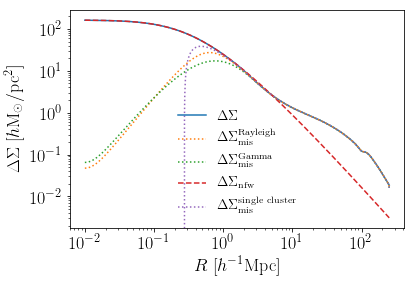

In [14]:
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(Rp, DeltaSigma_g2d, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm Rayleigh}$")
plt.loglog(Rp, DeltaSigma_exp, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm Gamma}$")
plt.loglog(Rp, DeltaSigma_nfw, ls="--", label=r"$\Delta\Sigma_{\rm nfw}$")
plt.loglog(Rp, DeltaSigma_single, ls=":", label=r"$\Delta\Sigma_{\rm mis}^{\rm single\ cluster}$")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}$]")
plt.legend(frameon=False, fontsize=14)
#plt.gcf().savefig("DeltaSigma_example.png", dpi=500)

# Boost factors
The boost factor is the amount of dilution of the lensing signal because of cluster galaxies being mixed up in the source catalog. This is called the `boost factor` because one would noramlly use an estimate of this to boost or correct the $\Delta\Sigma$ data. Implemented in this repository is a module for $\mathcal{B}(R) = (1-f_{\rm cl})^{-1}$, or a boost factor model as a function of distance on the sky to the cluster center. At the moment there is only an NFW model implemented. This may change in the future.

Text(0,0.5,'$\\mathcal{B}(R)=(1-f_{\\rm cl})^{-1}$')

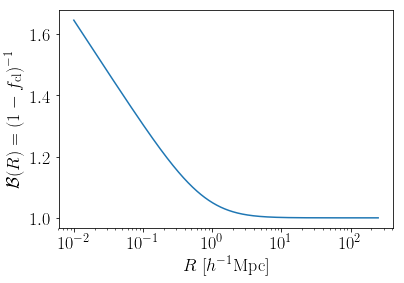

In [15]:
B0 = 0.15 #Typical NFW boost factor amplitude
Rs = 1.0 #Typical NFW boost factor scale radius, Mpc/h comoving
boost = cluster_toolkit.boostfactors.boost_nfw_at_R(Rp, B0, Rs)
plt.plot(Rp, boost)
plt.xscale('log')
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$\mathcal{B}(R)=(1-f_{\rm cl})^{-1}$")
#plt.gcf().savefig("boost_example.png", dpi=500)

# De-boosting the lensing
In DES, we treat the data as sacred. So instead of boosting the data and multiplying by $\mathcal{B}$, we divide $\mathcal{B}$ into the modeled $\Delta\Sigma$.

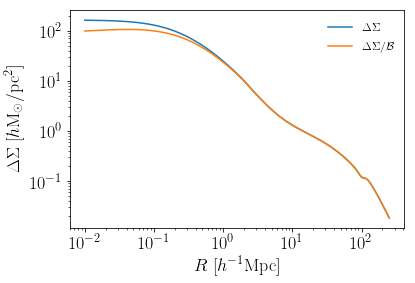

In [16]:
DeltaSigma = cluster_toolkit.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
B0 = 0.15 #Typical NFW boost factor amplitude
Rs = 1.0 #Typical NFW boost factor scale radius, Mpc/h comoving
boost = cluster_toolkit.boostfactors.boost_nfw_at_R(Rp, B0, Rs)
DeltaSigma_deboosted = DeltaSigma/boost
plt.loglog(Rp, DeltaSigma, ls="-", label=r"$\Delta\Sigma$")
plt.loglog(Rp, DeltaSigma_deboosted, ls="-", label=r"$\Delta\Sigma/\mathcal{B}$")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$\Delta\Sigma\ [h{\rm M_\odot/pc^2}$]")
plt.legend(loc=0, frameon=False, fontsize=12)
#plt.gcf().savefig("deboost_example.png", dpi=500)